This notebook provides example for multuple matching on MLP + MNIST. Two multuple matching methods are provided: (1) Reference matching, and (2) Sequential matching.

Multiple activation matching can be performed by replacing the weight matching function with the activation matching function. The usage of activation matching is shown in matching.ipynb.

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import torch.nn as nn
from source.utils.data_funcs import load_data
from source.utils.weight_matching import PermutationSpec, permutation_spec_from_axes_to_perm, get_wm_perm, apply_permutation
from source.utils.connect import interpolate_multi_state_dicts
from source.utils.logger import Logger
from torch.utils.data import DataLoader
from source.utils.train import train, validate
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
class MLP(nn.Module):
    def __init__(self, in_channels=1, use_bias=True, num_classes=10):
        super().__init__()
        self.fc0 = nn.Linear(in_channels*28*28, 120, bias=use_bias)
        self.relu0 = nn.ReLU()
        self.fc1 = nn.Linear(120, 84, bias=use_bias)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes, bias=use_bias)
    def forward(self, input):
        out = input.view(input.size(0), -1)
        out = self.fc0(out)
        out = self.relu0(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [4]:
def mlp_permutation_spec(num_hidden_layers: int, bias=True) -> PermutationSpec:
    """We assume that one permutation cannot appear in two axes of the same
    weight array."""
    assert num_hidden_layers >= 1
    if bias:
        bias_hidden = {f"fc{i}.bias": (f"P_{i}", )
                       for i in range(num_hidden_layers)}
        bias_last = {f"fc{num_hidden_layers}.bias": (None, )}
    else:
        bias_hidden, bias_last = {}, {}

    return permutation_spec_from_axes_to_perm({
        "fc0.weight": ("P_0", None),
        **{f"fc{i}.weight": (f"P_{i}", f"P_{i-1}")
           for i in range(1, num_hidden_layers)},
        **bias_hidden,
        f"fc{num_hidden_layers}.weight": (None, f"P_{num_hidden_layers-1}"),
        **bias_last,
    })

In [5]:
class config:
    model = 'mlp'
    dataset = 'mnist'
    data_dir = '../../Linear_Mode_Connectivity/data'
    print_freq = 100
    n = 11 # number of points on the line


In [6]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

In [7]:
use_bias = True
num_classes = 10
num = 8
model_s = [MLP(use_bias, num_classes).to(device) for _ in range(num)]
optimizer_s = [torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3) for model in model_s]

Training

In [ ]:
loss_s = [[] for _ in range(num)]
acc_s = [[] for _ in range(num)]
for epoch in range(5):
    for i, model in enumerate(model_s):
        loss, acc, _, _ = train(trainloader, model, criterion, optimizer_s[i], epoch, device, config)
        loss_s[i].append(loss)
        acc_s[i].append(acc)

Matching

In [15]:
res_dict = {'ori': {}, 'ref': {}, 'seq': {}}

In [ ]:
sd_s = [model.state_dict() for model in model_s]
ps = mlp_permutation_spec(2, use_bias)
perm_wm_s = [get_wm_perm(ps, sd_s[0], sd_s[i], device=device) for i in range(1, num)]
sd_wm_s = [apply_permutation(ps, perm_wm_s[i-1], sd_s[i], device) for i in range(1, num)]

sd_mid_s = [interpolate_multi_state_dicts(sd_s[:num], [1/num] * num) for num in range(1, 9)]
model_mid = MLP(use_bias, num_classes).to(device)

test_acc_s = []

for i in range(num):
    model_mid.load_state_dict(sd_mid_s[i])
    _, test_acc, _, _ = validate(testloader, model_mid, criterion, device, config)
    test_acc_s.append(test_acc)

In [17]:
res_dict['ori']['test_acc'] = deepcopy(test_acc_s)

In [ ]:
sd_mid_s = [interpolate_multi_state_dicts([sd_s[0]] + sd_wm_s[:num-1], [1/num] * num) for num in range(1, 9)]

test_acc_s = []

for i in range(num):
    model_mid.load_state_dict(sd_mid_s[i])
    _, test_acc, _, _ = validate(testloader, model_mid, criterion, device, config)
    test_acc_s.append(test_acc)

In [36]:
res_dict['ref']['test_acc'] = test_acc_s

In [ ]:
perm_wm_s = [get_wm_perm(ps, sd_s[0], sd_s[i], device=device) for i in range(1, num)]
sd_wm_s = [apply_permutation(ps, perm_wm_s[i-1], sd_s[i], device) for i in range(1, num)]

sd_wm_mid_s = [interpolate_multi_state_dicts([sd_s[0]] + sd_wm_s[:num-1], [1/num] * num) for num in range(1, 9)]

test_acc_s = []

for i in range(num):
    model_mid.load_state_dict(sd_wm_mid_s[i])
    _, test_acc, _, _ = validate(testloader, model_mid, criterion, device, config)
    test_acc_s.append(test_acc)

In [40]:
res_dict['seq']['test_acc'] = test_acc_s

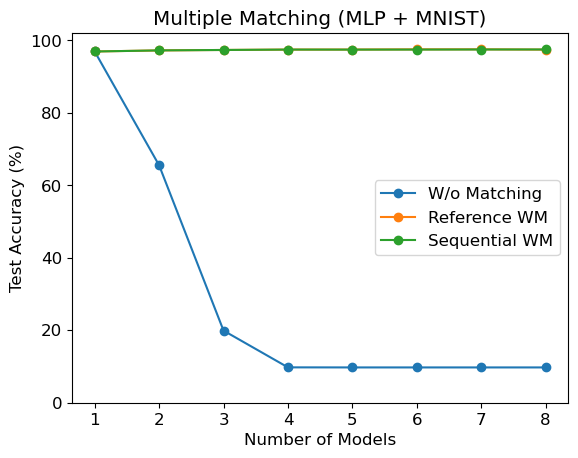

In [44]:
plt.rcParams.update({'font.size': 12})

x_axis = list(range(1, 9))
plt.plot(x_axis, res_dict['ori']['test_acc'], label='W/o Matching', marker='o')
plt.plot(x_axis, res_dict['ref']['test_acc'], label='Reference WM', marker='o')
plt.plot(x_axis, res_dict['seq']['test_acc'], label='Sequential WM', marker='o')
plt.title('Multiple Matching (MLP + MNIST)')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Number of Models')
plt.ylim(0, 102)
plt.legend()